In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn import preprocessing

In [2]:
#creazione di average_daily_hours
df = pd.read_csv("HR.csv")
df['average_daily_hours']=df['average_montly_hours']/21.5
df=df.drop(['average_montly_hours'], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,average_daily_hours
0,0.38,0.53,2,3,0,1,0,sales,low,7.302326
1,0.80,0.86,5,6,0,1,0,sales,medium,12.186047
2,0.11,0.88,7,4,0,1,0,sales,medium,12.651163
3,0.72,0.87,5,5,0,1,0,sales,low,10.372093
4,0.37,0.52,2,3,0,1,0,sales,low,7.395349


In [3]:
#vedere quali sono attributi categorici
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

sales     object
salary    object
dtype: object

In [4]:
#creare un dataset di training dal quale si tolgono gli attributi categorici e binari
df_train = df.drop(['sales', 'salary', 'Work_accident', 'left', 'promotion_last_5years'], axis=1)

In [35]:
df_train.head()

,satisfaction_level,last_evaluation,number_project,time_spend_company,average_daily_hours
0,0.38,0.53,2,3,7.302326
1,0.80,0.86,5,6,12.186047
2,0.11,0.88,7,4,12.651163
3,0.72,0.87,5,5,10.372093
4,0.37,0.52,2,3,7.395349


In [5]:
#min_max normalization su df_train
def normalize(attribute, min_attribute, max_attribute):
    result = []
    for i in attribute:
        new_value = (i - min_attribute)/(max_attribute - min_attribute)*(1-0)+0
        result.append(new_value)
    return result
min_number_project = min(df_train['number_project'])
max_number_project = max(df_train['number_project'])

min_time_spend_company = min(df_train['time_spend_company'])
max_time_spend_company = max(df_train['time_spend_company'])

min_average_daily_hours = min(df_train['average_daily_hours'])
max_average_daily_hours = max(df_train['average_daily_hours'])

df_train['normalized_number_project']=normalize(df_train['number_project'], min_number_project, max_number_project)
df_train= df_train.drop(['number_project'], axis=1)

df_train['normalized_time_spend_company']=normalize(df_train['time_spend_company'], min_time_spend_company, max_time_spend_company)
df_train= df_train.drop(['time_spend_company'], axis=1)

df_train['normalized_average_daily_hours']=normalize(df_train['average_daily_hours'], min_average_daily_hours, max_average_daily_hours)
df_train= df_train.drop(['average_daily_hours'], axis=1)

df_train.head()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours
0,0.38,0.53,0,0,0.285047
1,0.80,0.86,0,0,0.775701
2,0.11,0.88,1,0,0.822430
3,0.72,0.87,0,0,0.593458
4,0.37,0.52,0,0,0.294393


In [6]:
# conversione del DataFrame in un numpy array:
train_data = df_train.values
train_data

array([[ 0.38      ,  0.53      ,  0.        ,  0.        ,  0.28504673],
       [ 0.8       ,  0.86      ,  0.        ,  0.        ,  0.77570093],
       [ 0.11      ,  0.88      ,  1.        ,  0.        ,  0.82242991],
       ..., 
       [ 0.37      ,  0.53      ,  0.        ,  0.        ,  0.21962617],
       [ 0.11      ,  0.96      ,  0.        ,  0.        ,  0.85981308],
       [ 0.37      ,  0.52      ,  0.        ,  0.        ,  0.28971963]])

In [7]:
from sklearn.metrics import *
from sklearn.cluster import KMeans


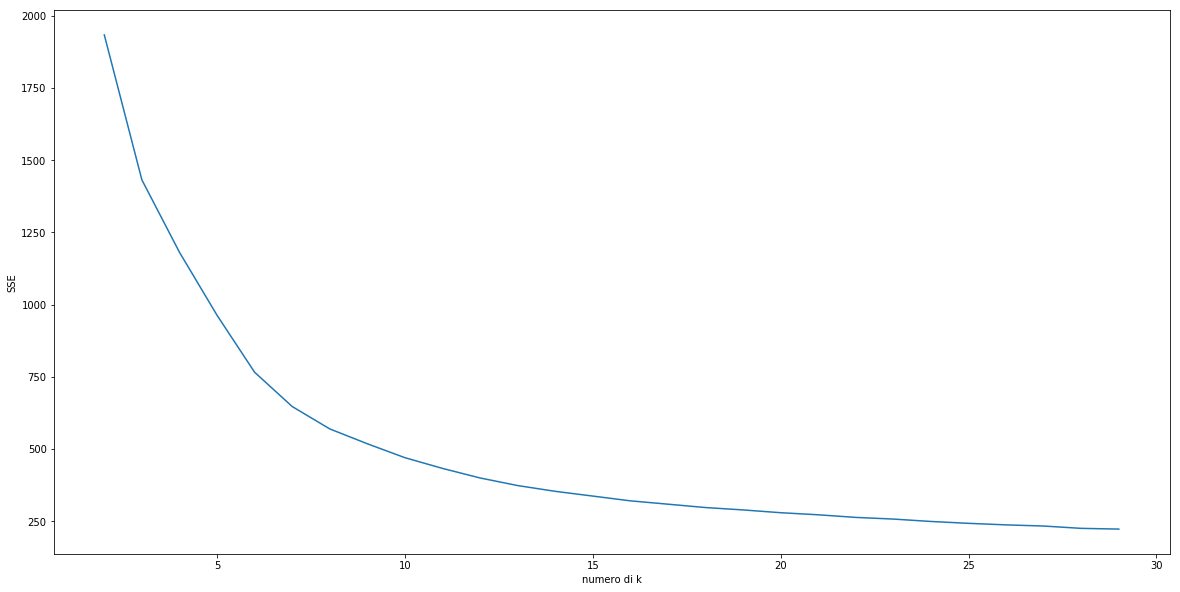

In [8]:
#identificazione del migliore valore di k: in base a questo grafico io sceglierei 11 come numero di k
sse_list = list()
max_k = 30
plt.rcParams['figure.figsize'] = (20, 10)
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.xlabel('numero di k')
plt.ylabel ('SSE')
plt.show()

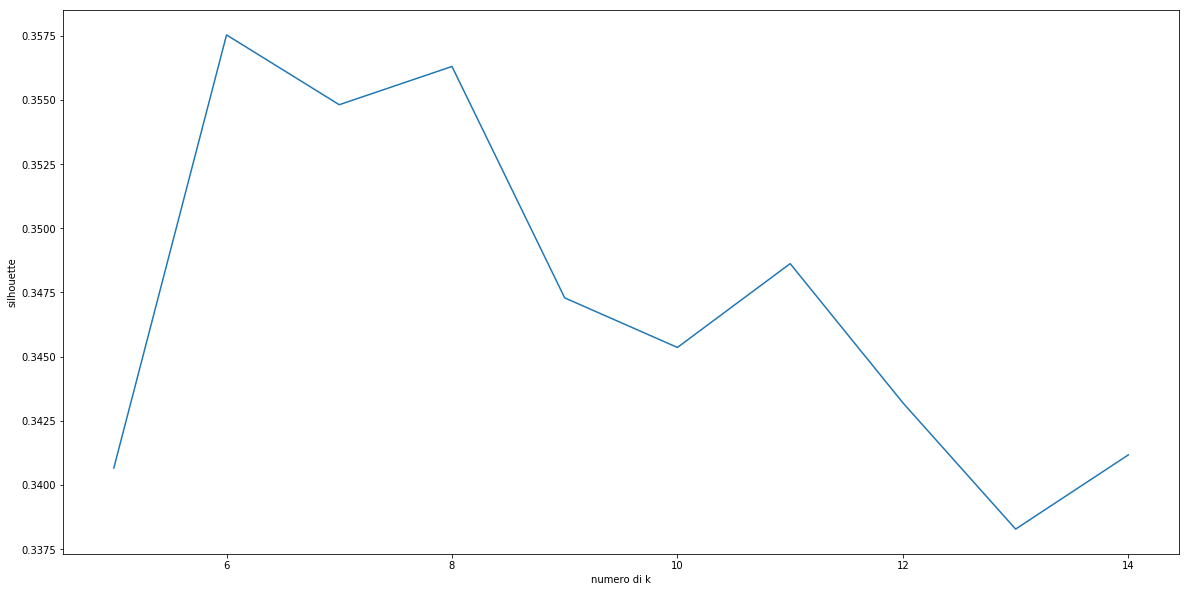

In [9]:
#identificazione del migliore valore di k in base a silhouette: in base a questo, invece, sceglierei 7, 
#anche se non so se l'uso della silhouette può essere giustificato nella scelta del numero k poichè la silhouette è 
#una misura di validazione del k-means
#NOTARE DAI RISULTATI SUCCESSIVI CHE LA SILHOUETTE TRA UN CLUSTERING CON 7 E UNO CON 11 DIFFERISCE SOLO DI 0.01 (Si tratta, arrotondando,
#di passare da 0.27 a 0.28)
#IN SOSTANZA, PER UN CLUSTERING CHE USA DA 8 A 11 CLUSTER SI HA UNA SILHOUETTE DI 0.27 (con arrotondamenti per eccesso) 
#E UNA SSE CHE VA DA 1189 A 1013(valore per k=11), mentre PER UN CLUSTERING CHE USA 7 CLUSTER SI HA UNA SILHOUETTE DI 0.28 
#E UNA SSE PIù ALTA DI 1276. 
#VALORE DELLA SILHOUETTE è IN TUTTI I CASI BASSO. 
#IO PRENDEREI 11 CLUSTER, TANTO LA VARIAZIONE DI SILHOUETTE MI SEMBRA POCA, A VANTAGGIO DI UN MINORE VALORE DI SSE (CHE DIFFERISCE AL MASSIMO DI PIù DI 2000 UNITà)
sil_list = list()
max_k = 15
plt.rcParams['figure.figsize'] = (20, 10)
for k in range(5,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sil = silhouette_score(train_data, kmeans.labels_)
    sil_list.append(sil)
plt.plot(range(5,max_k), sil_list)
plt.xlabel('numero di k')
plt.ylabel('silhouette')
plt.show()

In [10]:
#k-means con 7 clusters
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(train_data)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print ('centers', kmeans.cluster_centers_)
print ('labels', dict(zip(bins, hist)))
print ('sse', kmeans.inertia_)
print ('silhouette', silhouette_score(train_data, kmeans.labels_))

('centers', array([[  7.82583837e-01,   7.55973062e-01,  -4.37150316e-16,
         -6.27969898e-16,   3.11133004e-01],
       [  4.22101010e-01,   5.61189033e-01,  -4.30211422e-16,
         -5.41233725e-16,   2.50258257e-01],
       [  1.18710938e-01,   8.59609375e-01,   1.00000000e+00,
         -6.07153217e-17,   8.41486565e-01],
       [  1.72219081e-01,   8.05215548e-01,  -2.98372438e-16,
          4.51028104e-17,   7.41068657e-01],
       [  7.17979042e-01,   5.90868263e-01,  -4.05925293e-16,
          5.20417043e-18,   6.50734163e-01],
       [  6.55327103e-01,   7.31495327e-01,  -5.55111512e-17,
          1.00000000e+00,   4.82356538e-01],
       [  7.63554957e-01,   8.83881402e-01,  -4.26741975e-16,
         -4.71844785e-16,   6.76185998e-01]]))
('labels', {0: 3636, 1: 3462, 2: 256, 3: 1415, 4: 2671, 5: 214, 6: 3345})
('sse', 647.01559984221797)
('silhouette', 0.35499987481005729)


In [12]:
#k-means con 11 clusters ATTENZIONE: PRIMA DI ESEGUIRE RIESEGUIRE TUTTO SENZA ESEGUIRE IL KMEANS CON 7 CLUSTERS
kmeans = KMeans(init='k-means++', n_clusters=11, n_init=10, max_iter=100)
kmeans.fit(train_data)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print ('centers', kmeans.cluster_centers_)
print ('labels', dict(zip(bins, hist)))# numero di data object per ogni cluster (11, da 0 a 10)
print ('sse', kmeans.inertia_)
print ('silhouette', silhouette_score(train_data, kmeans.labels_))

('centers', array([[  8.58575233e-01,   6.09161119e-01,  -3.12250226e-16,
          1.11022302e-16,   6.51869159e-01],
       [  1.48553821e-01,   8.11889893e-01,  -2.60208521e-16,
         -1.38777878e-16,   7.64811587e-01],
       [  5.03742470e-01,   8.29969880e-01,  -2.84494650e-16,
         -2.77555756e-17,   3.11081945e-01],
       [  4.02496246e-01,   5.24204204e-01,  -4.02455846e-16,
          1.21430643e-17,   2.36777666e-01],
       [  1.18710938e-01,   8.59609375e-01,   1.00000000e+00,
         -6.07153217e-17,   8.41486565e-01],
       [  8.36436204e-01,   8.62168448e-01,  -3.22658567e-16,
          1.70002901e-16,   3.36104960e-01],
       [  6.55327103e-01,   7.31495327e-01,  -5.55111512e-17,
          1.00000000e+00,   4.82356538e-01],
       [  8.38366312e-01,   8.97676306e-01,  -3.60822483e-16,
          3.62557206e-16,   6.95545693e-01],
       [  5.93281493e-01,   8.50303266e-01,  -2.74086309e-16,
         -6.76542156e-17,   6.75404427e-01],
       [  5.70898438e-01,

In [11]:
#assegna ad ogni riga del dataset il cluster di appartenenza
df_clusters = df_train
df_clusters['Labels'] = kmeans.labels_
print (df_clusters)

       satisfaction_level  last_evaluation  normalized_number_project  \
0                    0.38             0.53                          0   
1                    0.80             0.86                          0   
2                    0.11             0.88                          1   
3                    0.72             0.87                          0   
4                    0.37             0.52                          0   
5                    0.41             0.50                          0   
6                    0.10             0.77                          0   
7                    0.92             0.85                          0   
8                    0.89             1.00                          0   
9                    0.42             0.53                          0   
10                   0.45             0.54                          0   
11                   0.11             0.81                          0   
12                   0.84             0.92         

In [41]:
df_clusters.describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,0.017068,0.014268,0.490889,3.210481
std,0.248631,0.171169,0.129528,0.118596,0.233379,1.735099
min,0.090000,0.360000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,0.000000,0.000000,0.280374,2.000000
50%,0.640000,0.720000,0.000000,0.000000,0.485981,3.000000
75%,0.820000,0.870000,0.000000,0.000000,0.696262,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [42]:
# DA USARE SE SI VOGLIONO PER OGNI CLUSTER INDICARE MEDIA, MINIMO, MASSIMO, NUMERO ELEMENTI DELLE VARIBILI DEL CLUSTERING E ANCHE ALTRE
df_clusters[df_clusters['Labels']==0].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,214.000000,214.000000,214.0,214.0,214.000000,214.0
mean,0.655327,0.731495,0.0,1.0,0.482357,0.0
std,0.217827,0.157521,0.0,0.0,0.221767,0.0
min,0.140000,0.370000,0.0,1.0,0.056075,0.0
25%,0.530000,0.617500,0.0,1.0,0.271028,0.0
50%,0.640000,0.730000,0.0,1.0,0.481308,0.0
75%,0.832500,0.867500,0.0,1.0,0.692757,0.0
max,0.990000,1.000000,0.0,1.0,0.878505,0.0


In [43]:
df_clusters[df_clusters['Labels']==1].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,3461.000000,3461.000000,3461.0,3461.0,3461.000000,3461.0
mean,0.421838,0.561049,0.0,0.0,0.250304,1.0
std,0.112555,0.116395,0.0,0.0,0.103256,0.0
min,0.100000,0.360000,0.0,0.0,0.000000,1.0
25%,0.370000,0.480000,0.0,0.0,0.182243,1.0
50%,0.420000,0.530000,0.0,0.0,0.242991,1.0
75%,0.490000,0.610000,0.0,0.0,0.299065,1.0
max,0.790000,1.000000,0.0,0.0,0.612150,1.0


In [17]:
df_clusters[df_clusters['Labels']==2].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,1330.000000,1330.000000,1330.0,1330.0,1330.000000,1330.0
mean,0.503286,0.830135,0.0,0.0,0.311282,2.0
std,0.133955,0.098236,0.0,0.0,0.111524,0.0
min,0.110000,0.620000,0.0,0.0,0.000000,2.0
25%,0.480000,0.750000,0.0,0.0,0.233645,2.0
50%,0.540000,0.830000,0.0,0.0,0.322430,2.0
75%,0.600000,0.910000,0.0,0.0,0.397196,2.0
max,0.680000,1.000000,0.0,0.0,0.532710,2.0


In [18]:
df_clusters[df_clusters['Labels']==3].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,2663.000000,2663.000000,2663.0,2663.0,2663.000000,2663.0
mean,0.402456,0.524179,0.0,0.0,0.236707,3.0
std,0.095730,0.071905,0.0,0.0,0.092148,0.0
min,0.100000,0.360000,0.0,0.0,0.000000,3.0
25%,0.370000,0.480000,0.0,0.0,0.182243,3.0
50%,0.410000,0.520000,0.0,0.0,0.233645,3.0
75%,0.450000,0.560000,0.0,0.0,0.285047,3.0
max,0.640000,0.800000,0.0,0.0,0.551402,3.0


In [19]:
df_clusters[df_clusters['Labels']==4].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,256.000000,256.000000,256.0,256.0,256.000000,256.0
mean,0.118711,0.859609,1.0,0.0,0.841487,4.0
std,0.075243,0.102689,0.0,0.0,0.135417,0.0
min,0.090000,0.460000,1.0,0.0,0.172897,4.0
25%,0.100000,0.830000,1.0,0.0,0.771028,4.0
50%,0.100000,0.880000,1.0,0.0,0.864486,4.0
75%,0.110000,0.930000,1.0,0.0,0.934579,4.0
max,0.660000,0.970000,1.0,0.0,1.000000,4.0


In [20]:
df_clusters[df_clusters['Labels']==5].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,1591.000000,1591.000000,1591.0,1591.0,1591.000000,1591.0
mean,0.836436,0.862168,0.0,0.0,0.336105,5.0
std,0.096617,0.081260,0.0,0.0,0.108111,0.0
min,0.650000,0.680000,0.0,0.0,0.000000,5.0
25%,0.750000,0.790000,0.0,0.0,0.257009,5.0
50%,0.830000,0.860000,0.0,0.0,0.341121,5.0
75%,0.920000,0.930000,0.0,0.0,0.425234,5.0
max,1.000000,1.000000,0.0,0.0,0.523364,5.0


In [21]:
df_clusters[df_clusters['Labels']==6].describe()

,satisfaction_level,last_evaluation,normalized_number_project,normalized_time_spend_company,normalized_average_daily_hours,Labels
count,214.000000,214.000000,214.0,214.0,214.000000,214.0
mean,0.655327,0.731495,0.0,1.0,0.482357,6.0
std,0.217827,0.157521,0.0,0.0,0.221767,0.0
min,0.140000,0.370000,0.0,1.0,0.056075,6.0
25%,0.530000,0.617500,0.0,1.0,0.271028,6.0
50%,0.640000,0.730000,0.0,1.0,0.481308,6.0
75%,0.832500,0.867500,0.0,1.0,0.692757,6.0
max,0.990000,1.000000,0.0,1.0,0.878505,6.0


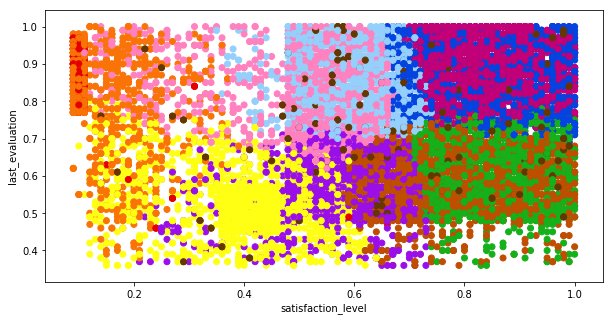

In [22]:
#scatterplot k-means CHE CASINO è???
plt.rcParams['figure.figsize'] = (10, 5)
LABEL_COLOR_MAP = {0 : 'xkcd:green',
                   1 : 'xkcd:orange',
                   2 : 'xkcd:pink',
                   3 : 'xkcd:yellow',
                   4 : 'xkcd:red',
                   5 : 'xkcd:blue',
                   6 : 'xkcd:brown',
                   7 : 'xkcd:magenta',
                   8 : 'xkcd:light blue',
                   9 : 'xkcd:violet',
                   10 : 'xkcd:burnt orange'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in df_clusters['Labels']]
plt.scatter(df_clusters['satisfaction_level'], df_clusters['last_evaluation'], c=label_color)
plt.xlabel('satisfaction_level')
plt.ylabel('last_evaluation')

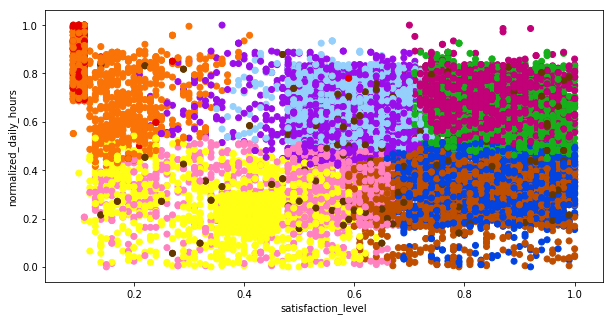

In [23]:
#scatterplot k-means CHE CASINO è???
LABEL_COLOR_MAP = {0 : 'xkcd:green',
                   1 : 'xkcd:orange',
                   2 : 'xkcd:pink',
                   3 : 'xkcd:yellow',
                   4 : 'xkcd:red',
                   5 : 'xkcd:blue',
                   6 : 'xkcd:brown',
                   7 : 'xkcd:magenta',
                   8 : 'xkcd:light blue',
                   9 : 'xkcd:violet',
                   10 : 'xkcd:burnt orange'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in df_clusters['Labels']]
plt.scatter(df_clusters['satisfaction_level'], df_clusters['normalized_average_daily_hours'], c=label_color)
plt.xlabel('satisfaction_level')
plt.ylabel('normalized_daily_hours')

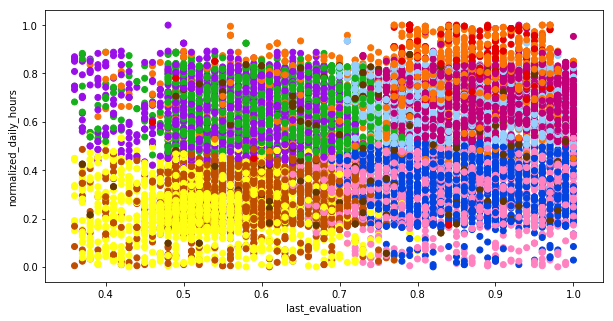

In [24]:
#scatterplot k-means CHE CASINO è???
LABEL_COLOR_MAP = {0 : 'xkcd:green',
                   1 : 'xkcd:orange',
                   2 : 'xkcd:pink',
                   3 : 'xkcd:yellow',
                   4 : 'xkcd:red',
                   5 : 'xkcd:blue',
                   6 : 'xkcd:brown',
                   7 : 'xkcd:magenta',
                   8 : 'xkcd:light blue',
                   9 : 'xkcd:violet',
                   10 : 'xkcd:burnt orange'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in df_clusters['Labels']]
plt.scatter(df_clusters['last_evaluation'], df_clusters['normalized_average_daily_hours'], c=label_color)
plt.xlabel('last_evaluation')
plt.ylabel('normalized_daily_hours')

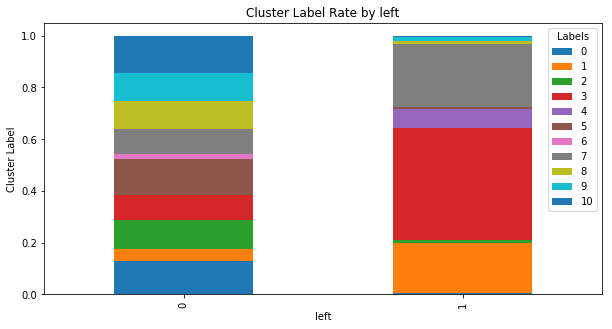

Labels,0,1,2,3,4,5,6,7,8,9,10
left,,,,,,,,,,,
0,1482,530,1283,1115,0,1561,214,1102,1240,1230,1671
1,20,685,47,1548,256,30,0,872,43,51,19


In [25]:
#crosstab: QUANTE PERSONE CHE HANNO LASCIATO O NON HANNO LASCIATO APPARTENGONO AD OGNI CLUSTER
left_xt = pd.crosstab(df['left'], df_clusters['Labels'])
left_xt_pct = left_xt.div(left_xt.sum(1).astype(float), axis=0)
left_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by left')
plt.xlabel('left')
plt.ylabel('Cluster Label')
plt.show()
left_xt

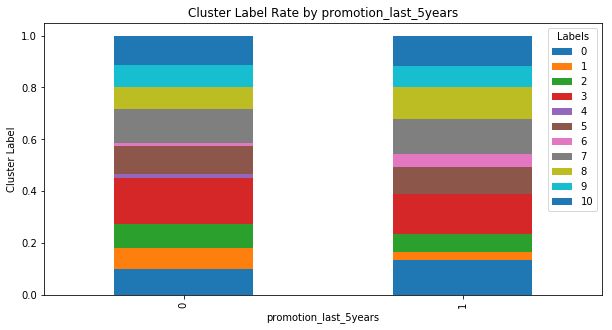

Labels,0,1,2,3,4,5,6,7,8,9,10
promotion_last_5years,,,,,,,,,,,
0,1460,1204,1308,2614,256,1558,198,1931,1243,1255,1653
1,42,11,22,49,0,33,16,43,40,26,37


In [26]:
#crosstab: QUANTE PERSONE CHE HANNO AVUTO PROMOZIONI O NON HANNO AVUTO PROMOZIONI APPARTENGONO AD OGNI CLUSTER
prom_xt = pd.crosstab(df['promotion_last_5years'], df_clusters['Labels'])
prom_xt_pct = prom_xt.div(prom_xt.sum(1).astype(float), axis=0)
prom_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by promotion_last_5years')
plt.xlabel('promotion_last_5years')
plt.ylabel('Cluster Label')
plt.show()
prom_xt

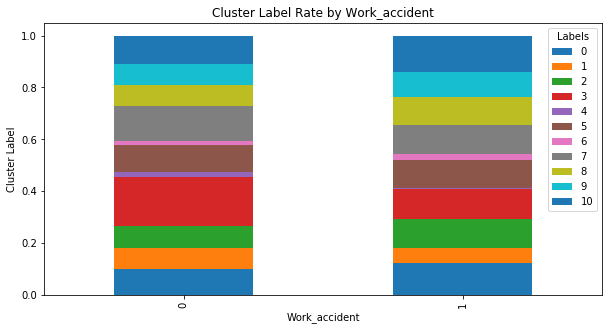

Labels,0,1,2,3,4,5,6,7,8,9,10
Work_accident,,,,,,,,,,,
0,1242,1085,1088,2409,252,1355,164,1731,1043,1077,1384
1,260,130,242,254,4,236,50,243,240,204,306


In [27]:
#crosstab: QUANTE PERSONE CHE HANNO AVUTO INCIDENTI O NON HANNO AVUTO INCIDENTI APPARTENGONO AD OGNI CLUSTER
work_xt = pd.crosstab(df['Work_accident'], df_clusters['Labels'])
work_xt_pct = work_xt.div(work_xt.sum(1).astype(float), axis=0)
work_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Work_accident')
plt.xlabel('Work_accident')
plt.ylabel('Cluster Label')
plt.show()
work_xt

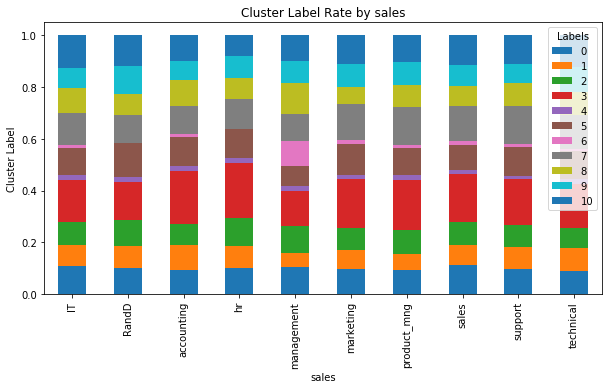

Labels,0,1,2,3,4,5,6,7,8,9,10
sales_val,,,,,,,,,,,
0,132,99,109,202,20,129,16,153,116,97,154
1,79,66,79,118,13,104,0,85,64,84,95
2,70,76,63,155,15,86,10,81,78,57,76
3,74,62,81,157,13,84,0,87,60,63,58
4,65,36,64,85,13,48,62,66,75,52,64
5,83,62,75,161,15,102,12,119,57,76,96
6,83,57,84,174,16,95,10,133,77,79,94
7,461,324,370,762,67,401,58,561,317,345,474
8,218,185,191,394,26,253,26,324,197,168,247


In [28]:
#crosstab: QUANTE PERSONE DI OGNI DIPARTIMENTO APPARTENGONO AD OGNI CLUSTER
sales_int= sorted(df['sales'].unique())
sales_int_mapping = dict(zip(sales_int, range(0, len(sales_int) + 1)))
df['sales_val'] = df['sales'].map(sales_int_mapping).astype(int)

sales_val_xt = pd.crosstab(df['sales_val'], df_clusters['Labels'])
sales_val_xt_pct = sales_val_xt.div(sales_val_xt.sum(1).astype(float), axis=0)
sales_val_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by sales')
plt.xticks(np.arange(10),('IT', 'RandD', 'accounting', 'hr', 'management', 'marketing', 'product_mng', 'sales', 'support', 'technical'))
plt.xlabel('sales')
plt.ylabel('Cluster Label')
plt.show()
sales_val_xt

#plt.legend(('low', 'medium', 'high'), loc='best')


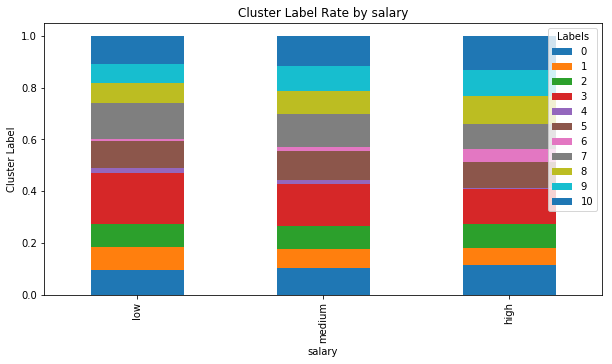

Labels,0,1,2,3,4,5,6,7,8,9,10
salary_val,,,,,,,,,,,
0,703,656,632,1462,144,740,56,1024,576,539,784
1,655,481,583,1032,109,727,94,831,574,617,743
2,144,78,115,169,3,124,64,119,133,125,163


In [29]:
#crosstab: QUANTE PERSONE CON UN DATO SALARIO APPARTENGONO AD OGNI CLUSTER
salary_int= sorted(df['salary'].unique())
salary_int_mapping = dict(zip(salary_int, [2, 0, 1])) #n ordine crescente di salario
df['salary_val'] = df['salary'].map(salary_int_mapping).astype(int)

salary_val_xt = pd.crosstab(df['salary_val'], df_clusters['Labels'])
salary_val_xt_pct = salary_val_xt.div(salary_val_xt.sum(1).astype(float), axis=0)
salary_val_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by salary')
plt.xticks(np.arange(3),('low', 'medium', 'high'))
plt.xlabel('salary')
plt.ylabel('Cluster Label')
plt.show()
salary_val_xt


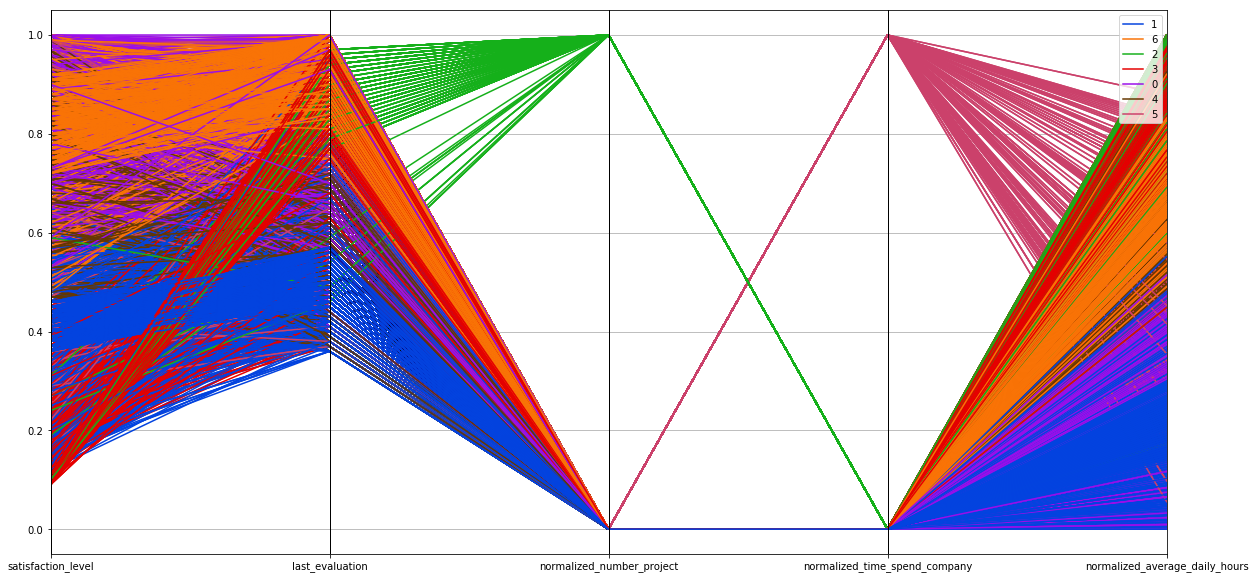

In [12]:
plt.rcParams['figure.figsize'] = (20, 10)
from pandas.plotting import parallel_coordinates
parallel_coordinates(df_clusters, 'Labels', color=['xkcd:blue', 'xkcd:orange', 'xkcd:green', 'xkcd:red', 'xkcd:violet', 'xkcd:brown', 'xkcd:dark pink'])